In [4]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lakshmimaniram","key":"f970366de3a17a91ceb9adbb9bc03203"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [7]:
!kaggle competitions download -c house-prices-advanced-regression-techniques -p /content
!unzip -o /content/house-prices-advanced-regression-techniques.zip -d /content


  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 392MB/s]
Archive:  /content/house-prices-advanced-regression-techniques.zip
  inflating: /content/data_description.txt  
  inflating: /content/sample_submission.csv  
  inflating: /content/test.csv       
  inflating: /content/train.csv      


In [9]:
# ===== 0. Setup (run first) =====
!pip install -q xgboost category_encoders kaggle

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import category_encoders as ce
%matplotlib inline

# Dataset paths (already downloaded into /content/)
TRAIN_CSV = '/content/train.csv'
TEST_CSV  = '/content/test.csv'

# Load dataset
df = pd.read_csv(TRAIN_CSV)
df.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Shape: (1460, 81)
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


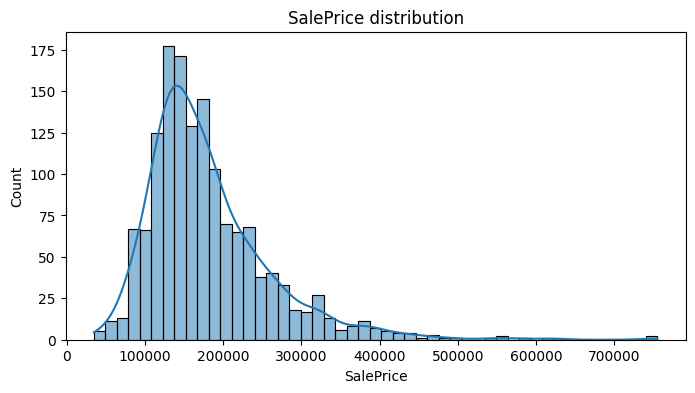

Top numeric features correlated with SalePrice:
 SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
Name: SalePrice, dtype: float64


In [11]:
#EDA
# ===== 1. Quick EDA =====
print("Shape:", df.shape)
print(df['SalePrice'].describe())

# Distribution of target
plt.figure(figsize=(8,4))
sns.histplot(df['SalePrice'], kde=True)
plt.title('SalePrice distribution')
plt.show()

# Correlation with SalePrice (top 15)
corrs = df.corr(numeric_only=True)['SalePrice'].abs().sort_values(ascending=False)
print("Top numeric features correlated with SalePrice:\n", corrs.head(15))


In [12]:
# ===== 2. Basic preprocessing strategy =====
# We'll:
# - separate numeric and categorical features
# - impute missing values (median for numeric, constant or 'Missing' for categorical)
# - encode categoricals with OneHot for low-cardinality and Target/Ordinal or CatBoost/WOE for others.
# - scale numeric features.

# Basic feature lists (we'll derive from dataframe)
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_features.remove('SalePrice')  # target removed
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

print("Numeric count:", len(numeric_features), "Categorical count:", len(categorical_features))


Numeric count: 37 Categorical count: 43


In [13]:
# A pragmatic feature reduction:
# keep numeric features and top k categorical by cardinality threshold — this keeps pipeline fast for demo.

# If you want to use all features, skip this reduction.
cat_cardinality = df[categorical_features].nunique().sort_values()
print(cat_cardinality.head(20))

# Choose low-cardinality for one-hot, and high-cardinality for target/ordinal encoding
low_card_thresh = 10
low_card_cats = [c for c in categorical_features if df[c].nunique() <= low_card_thresh]
high_card_cats = [c for c in categorical_features if df[c].nunique() > low_card_thresh]

print("Low-cardinality categoricals:", len(low_card_cats))
print("High-cardinality categoricals:", len(high_card_cats))


Street          2
Alley           2
Utilities       2
CentralAir      2
MasVnrType      3
LandSlope       3
PavedDrive      3
GarageFinish    3
PoolQC          3
ExterQual       4
BsmtQual        4
BsmtExposure    4
BsmtCond        4
KitchenQual     4
LandContour     4
LotShape        4
Fence           4
MiscFeature     4
ExterCond       5
Electrical      5
dtype: int64
Low-cardinality categoricals: 40
High-cardinality categoricals: 3


In [15]:
# ===== 3. Build preprocessing pipelines =====
# Numeric pipeline
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Low-cardinality categorical pipeline -> OneHot
low_card_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    (OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# High-cardinality -> Target encoding (using category_encoders)
# We'll use LeaveOneOut or Target encoder for higher-cardinality categories to avoid explosion
# NOTE: Category encoders require training target, so we'll integrate using a wrapper later OR use mean encoding manually.
# For simplicity we'll use OrdinalEncoder-like approach with category_encoders.TargetEncoder
high_card_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('target_enc', ce.TargetEncoder())   # This encoder will be fitted within pipeline with y during training
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('lowcat', low_card_pipeline, low_card_cats),
    ('highcat', high_card_pipeline, high_card_cats)
], remainder='drop')

# Note: XGBoost and tree models can handle unscaled features; but we scale for linear model fairness.


In [ ]:
# ===== 4. Prepare X, y and train/validation split =====
X = df.drop(columns=['SalePrice'])
y = df['SalePrice']

# Small log-transform of target helps many models
y_log = np.log1p(y)

X_train, X_val, y_train_log, y_val_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

print("Train size:", X_train.shape, "Val size:", X_val.shape)


In [16]:
# ===== 5. Define model training helper + evaluation metrics =====
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def evaluate_model(model, X_tr, y_tr, X_v, y_v, do_print=True):
    model.fit(X_tr, y_tr)
    pred_tr = model.predict(X_tr)
    pred_v  = model.predict(X_v)
    # predictions are on log-scale -> invert
    pred_tr_exp = np.expm1(pred_tr)
    pred_v_exp  = np.expm1(pred_v)
    y_tr_exp = np.expm1(y_tr)
    y_v_exp  = np.expm1(y_v)
    results = {
        'train_RMSE': rmse(y_tr_exp, pred_tr_exp),
        'val_RMSE': rmse(y_v_exp, pred_v_exp),
        'train_MAE': mean_absolute_error(y_tr_exp, pred_tr_exp),
        'val_MAE': mean_absolute_error(y_v_exp, pred_v_exp),
        'train_R2': r2_score(y_tr_exp, pred_tr_exp),
        'val_R2': r2_score(y_v_exp, pred_v_exp),
    }
    if do_print:
        for k,v in results.items():
            print(f"{k}: {v:.4f}")
    return results


In [18]:
# ===== 5.2 Train/Validation split =====
# Features and target
y = df["SalePrice"]
X = df.drop("SalePrice", axis=1)

# Log-transform target to reduce skewness
y_log = np.log1p(y)

# Train/validation split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train_log, y_val_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)


Train shape: (1168, 80)
Validation shape: (292, 80)


In [20]:
#cell 5.3
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Separate numeric and categorical columns
numeric_cols = X_train.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

# Pipelines
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_cols),
    ('cat', categorical_pipeline, categorical_cols)
])


In [21]:
# ===== 6. Model 1: Linear Regression (baseline) =====
model_lr = Pipeline([
    ('preproc', preprocessor),
    ('reg', LinearRegression())
])

print("Training Linear Regression baseline...")
res_lr = evaluate_model(model_lr, X_train, y_train_log, X_val, y_val_log)


Training Linear Regression baseline...
train_RMSE: 17372.9266
val_RMSE: 22907.1669
train_MAE: 10986.4759
val_MAE: 15070.3388
train_R2: 0.9494
val_R2: 0.9316


In [22]:
# ===== 7. Model 2: Random Forest Regressor =====
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

pipe_rf = Pipeline([
    ('preproc', preprocessor),
    ('rf', rf)
])

# quick default train
print("Training default Random Forest...")
res_rf = evaluate_model(pipe_rf, X_train, y_train_log, X_val, y_val_log)

# Optionally tune a couple hyperparameters (small grid)
param_grid = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [10, 20, None],
    'rf__min_samples_split': [2, 5]
}
gs = GridSearchCV(pipe_rf, param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=1, verbose=1)
# Fit grid search (can take time)
gs.fit(X_train, y_train_log)
print("Best params (RF):", gs.best_params_)
best_rf = gs.best_estimator_
# evaluate
res_rf_tuned = evaluate_model(best_rf, X_train, y_train_log, X_val, y_val_log)


Training default Random Forest...
train_RMSE: 11329.0567
val_RMSE: 30174.3491
train_MAE: 6677.7964
val_MAE: 17758.7922
train_R2: 0.9785
val_R2: 0.8813
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params (RF): {'rf__max_depth': 20, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
train_RMSE: 11185.5891
val_RMSE: 29913.4193
train_MAE: 6603.5215
val_MAE: 17778.9180
train_R2: 0.9790
val_R2: 0.8833


In [23]:
# ===== 8. Model 3: XGBoost =====
xg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

pipe_xgb = Pipeline([
    ('preproc', preprocessor),
    ('xgb', xg)
])

print("Training default XGBoost...")
res_xgb = evaluate_model(pipe_xgb, X_train, y_train_log, X_val, y_val_log)

# Quick hyperparam tuning
param_grid_xgb = {
    'xgb__n_estimators': [100, 300],
    'xgb__max_depth': [3, 6],
    'xgb__learning_rate': [0.05, 0.1]
}
gs_xgb = GridSearchCV(pipe_xgb, param_grid_xgb, cv=3, scoring='neg_root_mean_squared_error', n_jobs=1, verbose=1)
gs_xgb.fit(X_train, y_train_log)
print("Best params (XGB):", gs_xgb.best_params_)
best_xgb = gs_xgb.best_estimator_
res_xgb_tuned = evaluate_model(best_xgb, X_train, y_train_log, X_val, y_val_log)


Training default XGBoost...
train_RMSE: 923.9664
val_RMSE: 27958.0591
train_MAE: 633.3000
val_MAE: 17708.2464
train_R2: 0.9999
val_R2: 0.8981
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best params (XGB): {'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 300}
train_RMSE: 9874.4924
val_RMSE: 27563.5432
train_MAE: 6992.4823
val_MAE: 16333.2694
train_R2: 0.9837
val_R2: 0.9009


In [24]:
# ===== 9. Compare models =====
comparison = pd.DataFrame([
    {'model':'LinearRegression', **res_lr},
    {'model':'RandomForest_default', **res_rf},
    {'model':'RandomForest_tuned', **res_rf_tuned},
    {'model':'XGB_default', **res_xgb},
    {'model':'XGB_tuned', **res_xgb_tuned},
])
comparison = comparison[['model','val_RMSE','val_MAE','val_R2','train_RMSE','train_R2']]
comparison.sort_values('val_RMSE')


,model,val_RMSE,val_MAE,val_R2,train_RMSE,train_R2
0,LinearRegression,22907.166947,15070.338761,0.931589,17372.926580,0.949398
4,XGB_tuned,27563.543231,16333.269397,0.900950,9874.492415,0.983652
3,XGB_default,27958.059113,17708.246361,0.898094,923.966357,0.999857
2,RandomForest_tuned,29913.419279,17778.918015,0.883341,11185.589076,0.979023
1,RandomForest_default,30174.349147,17758.792235,0.881297,11329.056715,0.978482


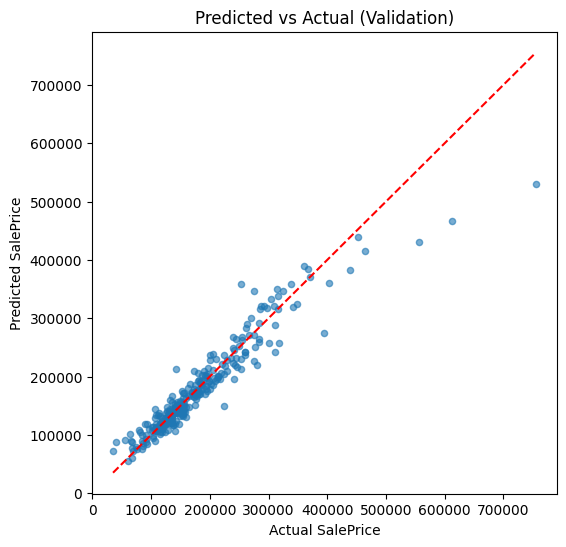

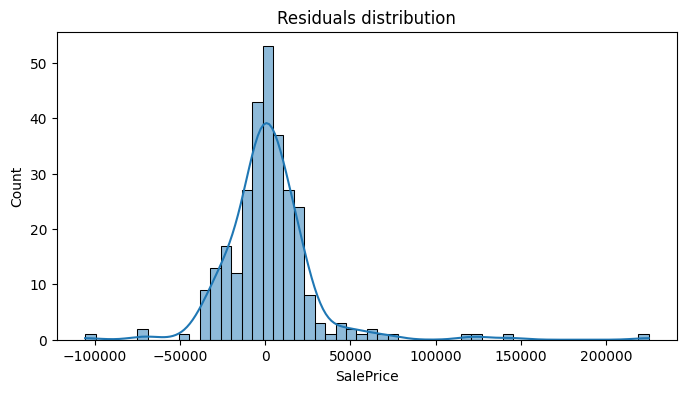

In [25]:
# ===== 10. Visualize predictions vs actual for best model (example uses best_xgb) =====
best_model = best_xgb  # choose the best from comparison
# Fit on full training portion (optional)
best_model.fit(X_train, y_train_log)

pred_val_log = best_model.predict(X_val)
pred_val = np.expm1(pred_val_log)
actual_val = np.expm1(y_val_log)

plt.figure(figsize=(6,6))
plt.scatter(actual_val, pred_val, alpha=0.6, s=20)
plt.plot([actual_val.min(), actual_val.max()], [actual_val.min(), actual_val.max()], 'r--')
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title('Predicted vs Actual (Validation)')
plt.show()

# residuals
resids = actual_val - pred_val
plt.figure(figsize=(8,4))
sns.histplot(resids, kde=True)
plt.title('Residuals distribution')
plt.show()


In [26]:
# ===== 11. Save best model and preprocessing pipeline =====
import joblib
joblib.dump(best_model, 'best_house_price_model.pkl')
print("Saved model to best_house_price_model.pkl")


Saved model to best_house_price_model.pkl


In [27]:
# ===== 12. (Optional) Predict test.csv and prepare Kaggle submission =====
import os

if os.path.exists(TEST_CSV):
    test_df = pd.read_csv(TEST_CSV)
    preds_test_log = best_model.predict(test_df)
    preds_test = np.expm1(preds_test_log)
    submission = pd.DataFrame({'Id': test_df['Id'], 'SalePrice': preds_test})
    submission.to_csv('submission.csv', index=False)
    print("Wrote submission.csv")
else:
    print("test.csv not found; upload it to create a submission.")


Wrote submission.csv


In [28]:
from google.colab import files
files.download('submission.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>